In [24]:
import numpy as np
import pandas as pd
import seaborn as sns

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json

from keras.regularizers import l1

from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import datetime

import plotly as py
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.graph_objs import Data,Figure

from sklearn.preprocessing import  StandardScaler, MinMaxScaler



In [25]:
# PREPROCESSING

# attach the column names to the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# open the csv dataset
df = pd.read_csv("kddcup.data_10_percent.gz",compression='gzip',header=None, names = col_names)

# Remove smurf and neptune attacks
df = df[df.label != 'smurf.']
df = df[df.label != 'neptune.']

# Remove duplicates
df.drop_duplicates(subset=None, keep='first', inplace=True)

# One hot encoding
cols_to_dummify = ['protocol_type','service','flag']
data_dummy = pd.get_dummies(df, columns=cols_to_dummify, prefix=cols_to_dummify)

# Splitting train/test
X = data_dummy.values

RANDOM_SEED = 87 #penser a changer la seed a posteriori pour voir
X_train, X_test = train_test_split(data_dummy, test_size=0.2, random_state = RANDOM_SEED)

X_train = X_train[X_train['label'] == 'normal.' ] # Only train on normal data (no intrusion)
# X_test = X_test[X_test['label'] == 'normal.']
X_train = X_train.drop(['label'], axis=1)
y_test  = X_test['label']
X_test  = X_test.drop(['label'], axis=1)
X_train = X_train.values
X_test  = X_test.values

# Standardize/Normalize dataset?
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print('Training data size   :', X_train.shape)
print('Validation(test) data size :', X_test.shape)
data_dummy.head()


Training data size   : (70306, 109)
Validation(test) data size : (18625, 109)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,181,5450,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,239,486,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,235,1337,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,219,1337,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,217,2032,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
#MODEL BUILDING
input_dim = X_train.shape[1]
encoding_dim = 6

# Sequential
autoencoder_seq = Sequential()
autoencoder_seq.add(Dense(input_dim, input_shape=(input_dim,)))
autoencoder_seq.add(Dense(encoding_dim, activation="tanh"))
autoencoder_seq.add(Dense(int(encoding_dim/2),activation="tanh"))
autoencoder_seq.add(Dense(2,activation="tanh"))
autoencoder_seq.add(Dense(int(encoding_dim/2),activation="tanh"))
autoencoder_seq.add(Dense(encoding_dim,activation="tanh"))
autoencoder_seq.add(Dense(input_dim,activation="tanh"))
autoencoder_seq.compile(optimizer='adam', loss='mse',
             metrics=['accuracy'])
autoencoder_seq.summary()

# Functional 
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder_func = Model(inputs=input_layer, outputs=decoder)
autoencoder_func.compile(optimizer='adam', loss='mse', metrics=['accuracy'] )
autoencoder_func.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 109)               11990     
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 660       
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 24        
_________________________________________________________________
dense_20 (Dense)             (None, 109)               763       
Total para

In [27]:
# MODEL TRAINING

nb_epoch = 25
batch_size = 50


t_ini = datetime.datetime.now()
history = autoencoder_func.fit(X_train_scaled, X_train_scaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        validation_split=0.1,
                        shuffle=True
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))


df_history = pd.DataFrame(history.history)

Train on 63275 samples, validate on 7031 samples
Epoch 1/25
63275/63275 [==============================] - 3s 41us/step - loss: 0.0175 - acc: 6.1636e-04 - val_loss: 0.0115 - val_acc: 0.0000e+00
Epoch 2/25
63275/63275 [==============================] - 2s 34us/step - loss: 0.0102 - acc: 2.8447e-04 - val_loss: 0.0086 - val_acc: 4.2668e-04
Epoch 3/25
63275/63275 [==============================] - 2s 33us/step - loss: 0.0067 - acc: 7.1118e-04 - val_loss: 0.0059 - val_acc: 0.0013
Epoch 4/25
63275/63275 [==============================] - 2s 38us/step - loss: 0.0055 - acc: 0.0322 - val_loss: 0.0052 - val_acc: 0.0794
Epoch 5/25
63275/63275 [==============================] - 2s 37us/step - loss: 0.0051 - acc: 0.0842 - val_loss: 0.0051 - val_acc: 0.0748
Epoch 6/25
63275/63275 [==============================] - 2s 36us/step - loss: 0.0050 - acc: 0.0828 - val_loss: 0.0050 - val_acc: 0.0772
Epoch 7/25
63275/63275 [==============================] - 2s 34us/step - loss: 0.0049 - acc: 0.0841 - val_los

In [69]:
# MODEL EVALUATION

pyo.init_notebook_mode(connected=True)
trace = []
for label, loss in zip(['Train', 'Validation'], ['loss', 'val_loss']):
    trace0 = {'type' : 'scatter', 
              'x'    : df_history.index.tolist(),
              'y'    : df_history[loss].tolist(),
              'name' : label,
              'mode' : 'lines'
              }
        
    trace.append(trace0)
data = Data(trace)
layout = {'title' : 'Model train-vs-validation loss', 'titlefont':{'size' : 30},
          'xaxis' : {'title':  '<b> Epochs', 'titlefont':{ 'size' : 25}},
          'yaxis' : {'title':  '<b> Loss', 'titlefont':{ 'size' : 25}},
          }
fig = Figure(data = data, layout = layout)
    
pyo.iplot(fig)

In [70]:
# PREDICTION

thresh = 0.025

def line_plot(df, col):
    
    x = df.index.tolist()
    y = df[col].tolist()
    
    trace = {'type':  'scatter', 
             'x'   :  x,
             'y'   :  y,
             'mode' : 'markers'
            }
    data   = Data([trace])
    layout = {'title': 'Line plot of {}'.format(col), 'titlefont': {'size': 30},
              'xaxis' : {'title' :'Data Index', 'titlefont': {'size' : 20}},
              'yaxis' : {'title': col, 'titlefont' : {'size': 20}},
              'hovermode': 'closest'
             }
    fig = Figure(data = data, layout = layout)
    return fig

predictions = autoencoder_func.predict(X_test_scaled)
predictions_train = autoencoder_func.predict(X_train_scaled[:18625])

mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)
mse_train = np.mean(np.power(X_train_scaled[:18625] - predictions_train, 2), axis=1)

df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': y_test, 
                         'reconstruction_error_train':mse_train}, index=y_test.index)
print(df_error.describe())

outliers = df_error.index[df_error.reconstruction_error > thresh].tolist()
print(len(outliers))

pyo.iplot(line_plot(df_error,'reconstruction_error'))


       reconstruction_error  reconstruction_error_train
count          18625.000000                18625.000000
mean               0.007569                    0.004350
std                0.017125                    0.005550
min                0.000041                    0.000040
25%                0.001717                    0.001637
50%                0.002094                    0.002007
75%                0.006448                    0.004808
max                0.136262                    0.083700
949


In [71]:
# INTERPRETATION

data_n = pd.DataFrame(X_test_scaled, index= y_test.index, columns=data_dummy.columns[:109])

def compute_error_per_dim(point):
    
    initial_pt = np.array(data_n.loc[point,:]).reshape(1,109)
    reconstructed_pt = autoencoder_func.predict(initial_pt)
    
    return abs(np.array(initial_pt  - reconstructed_pt)[0])

def bar_plot(df, data_pt):
    x = df.columns.tolist()
    y = df.loc[data_pt]
    
    trace = {'type': 'bar',
             'x'   : x,
             'y'   : y}
    data = Data([trace])
    layout = {'title' : "<b>Reconstruction error in each dimension for data poitn {}".format(data_pt),
              'titlefont':{'size' : 20},
              'xaxis' : {'title': '<b>Features',
                         'titlefont':{'size' : 20},
                         'tickangle': -45, 'tickfont': {'size':15} },
              'yaxis' : {'title': '<b>Reconstruction Error',
                         'titlefont':{'size' : 20},
                         'tickfont': {'size':15}},
              'margin' : {'l':100, 'r' : 1, 'b': 200, 't': 100, 'pad' : 1},
              'height' : 600, 'width' : 800,
             }
    
    fig = Figure(data = data, layout = layout)
    
    return pyo.iplot(fig)

RE_per_dim = {}
for ind in outliers:
    RE_per_dim[ind] = compute_error_per_dim(ind)
    
RE_per_dim = pd.DataFrame(RE_per_dim).T


for pt in outliers[0:5]:
    bar_plot(RE_per_dim,pt)



Conclusion: les caractéristiques permettant de discriminer un point comme intrusion sont: src_bytes, dst_bytes, dst_host_srv_count, et dst_host_count 

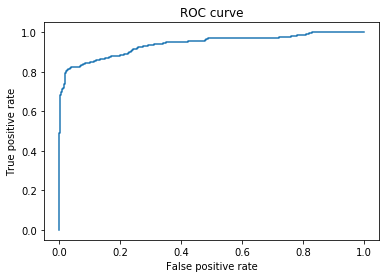

In [72]:
# ROC Curve

target = [0 if e=='normal.' else 1 for e in y_test]
predicted = [0 if e<=thresh else 1 for e in df_error['reconstruction_error']]

fpr, tpr, thresholds = roc_curve(target, df_error['reconstruction_error'])

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

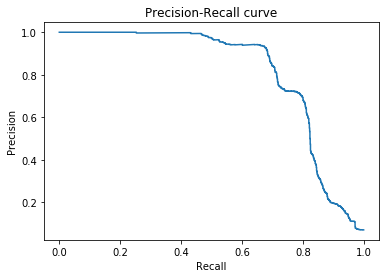

In [73]:
# Precision recall curve
precision, recall, thresholds = precision_recall_curve(target, df_error['reconstruction_error'])

# PLOT
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

In [74]:
# Confusion matrix

np.set_printoptions(precision=2)

print(confusion_matrix(target, predicted))
plt.show()


[[17356   170]
 [  320   779]]
